## Business Understanding

### Business Context

Agriculture remains one of the world’s most vital economic sectors, providing food, employment, and raw materials for millions of people. Globally, agriculture contributes about 4% to the world’s GDP and employs nearly 26% of the global workforce, according to the World Bank (2024). Despite this importance, crop yields are increasingly affected by climate change, soil degradation, and fluctuating input costs, posing major risks to global food security.

The need to accurately predict crop yields has therefore become critical for decision-making in agribusiness, policymaking, and food supply management. Using statistical and machine learning methods, stakeholders can forecast yields based on factors such as temperature, rainfall, soil quality, and fertilizer use. These insights help optimize resource allocation, reduce financial losses, and enhance productivity across different regions and crop types.

### Business Problem
Unpredictable weather patterns, soil degradation, and rising input costs make global crop yield forecasting unreliable. This project aims to develop a data-driven model to predict yields of the 10 most consumed crops worldwide, improving food security and agribusiness decision-making.

## Data Understanding

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
 

print("LOADING ALL DATASETS...")
print("="*50)

# Load all datasets
yield_df = pd.read_csv('data/yield_df.csv')
yield_data = pd.read_csv('data/yield.csv')
pesticides = pd.read_csv('data/pesticides.csv')
rainfall = pd.read_csv('data/rainfall.csv')
temperature = pd.read_csv('data/temp.csv')

print("📊 DATASET OVERVIEW:")
datasets = {
    'yield_df.csv': yield_df,
    'yield.csv': yield_data,
    'pesticides.csv': pesticides,
    'rainfall.csv': rainfall,
    'temp.csv': temperature
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    print(f"  Missing values: {df.isnull().sum().sum()}")

LOADING ALL DATASETS...
📊 DATASET OVERVIEW:

yield_df.csv:
  Shape: (28242, 8)
  Columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
  Missing values: 0

yield.csv:
  Shape: (56717, 12)
  Columns: ['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value']
  Missing values: 0

pesticides.csv:
  Shape: (4349, 7)
  Columns: ['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
  Missing values: 0

rainfall.csv:
  Shape: (6727, 3)
  Columns: [' Area', 'Year', 'average_rain_fall_mm_per_year']
  Missing values: 774

temp.csv:
  Shape: (71311, 3)
  Columns: ['year', 'country', 'avg_temp']
  Missing values: 2547


- Explores yield_df.csv:
Shows first 3 rows
Counts unique countries
Lists unique crops
Displays year range

- Explores yield_data.csv:
Shows first 3 rows
Lists unique elements (e.g., yield, production)

- Explores pesticides.csv:
Shows first 3 rows
Explores rainfall.csv:
Shows first 3 rows

- Explores temperature.csv:
Shows first 3 rows

## Data Exploration

In [5]:
def explore_each_dataset():
    """Detailed exploration of each dataset"""
    
    print("\n🔍 DETAILED DATASET EXPLORATION")
    print("="*60)
    
    # 1. Yield DataFrame
    print("\n1. YIELD_DF.CSV:")
    print(yield_df.head(3))
    print(f"Unique countries: {yield_df['Area'].nunique()}")
    print(f"Unique crops: {yield_df['Item'].unique()}")
    print(f"Year range: {yield_df['Year'].min()} - {yield_df['Year'].max()}")
    
    # 2. Yield Data
    print("\n2. YIELD.CSV:")
    print(yield_data.head(3))
    print(f"Unique elements: {yield_data['Element'].unique()}")
    
    # 3. Pesticides
    print("\n3. PESTICIDES.CSV:")
    print(pesticides.head(3))
    
    # 4. Rainfall
    print("\n4. RAINFALL.CSV:")
    print(rainfall.head(3))
    
    # 5. Temperature
    print("\n5. TEMPERATURE.CSV:")
    print(temperature.head(3))

explore_each_dataset()


🔍 DETAILED DATASET EXPLORATION

1. YIELD_DF.CSV:
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
Unique countries: 101
Unique crops: ['Maize' 'Potatoes' 'Rice, paddy' 'Sorghum' 'Soybeans' 'Wheat' 'Cassava'
 'Sweet potatoes' 'Plantains and others' 'Yams']
Year range: 1990 - 2013

2. YIELD.CSV:
  Domain Code Domain  Area Code         Area  Element Code Element  Item Code  \
0          QC  Crops          2  Afghanistan          5419   Yield         56   
1          QC  Crops          2  Afghanistan          5419   Yield         56   
2          QC  Crops 

### Data Preparation

In [6]:
def integrate_datasets(yield_df, yield_data, pesticides, rainfall, temperature):
    """
    Integrate all datasets into a single master dataset
    """
    print("🔄 INTEGRATING ALL DATASETS...")
    
    # Start with the main yield dataframe
    master_df = yield_df.copy()
    
    print("1. Checking common keys for integration...")
    
    # Check common columns across datasets
    print(f"yield_df columns: {list(yield_df.columns)}")
    print(f"pesticides columns: {list(pesticides.columns)}")
    print(f"rainfall columns: {list(rainfall.columns)}")
    print(f"temperature columns: {list(temperature.columns)}")
    
    # Check if we need to merge additional data
    # If yield_df already has all columns, we might not need to merge
    if all(col in yield_df.columns for col in ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']):
        print("✅ yield_df.csv already contains integrated data (rainfall, pesticides, temperature)")
        return master_df
    else:
        print("🔄 Need to merge separate datasets...")
        # Integration logic would go here
        return master_df

# Integrate all datasets
master_df = integrate_datasets(yield_df, yield_data, pesticides, rainfall, temperature)
print(f"✅ Final master dataset shape: {master_df.shape}")

🔄 INTEGRATING ALL DATASETS...
1. Checking common keys for integration...
yield_df columns: ['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
pesticides columns: ['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
rainfall columns: [' Area', 'Year', 'average_rain_fall_mm_per_year']
temperature columns: ['year', 'country', 'avg_temp']
✅ yield_df.csv already contains integrated data (rainfall, pesticides, temperature)
✅ Final master dataset shape: (28242, 8)


- yield_df already contained the columns average_rain_fall_mm_per_year, pesticides_tonnes, and avg_temp,

- which are also present in the rainfall, pesticides, and temperature datasets respectively.

In [7]:
def assess_data_quality(df):
    """Comprehensive data quality assessment"""
    
    print("\n🧹 DATA QUALITY ASSESSMENT")
    print("="*50)
    
    # Basic info
    print(f"Dataset shape: {df.shape}")
    print(f"Total records: {len(df)}")
    
    # Missing values
    print("\nMissing values per column:")
    missing_data = df.isnull().sum()
    for col, missing_count in missing_data.items():
        if missing_count > 0:
            print(f"  {col}: {missing_count} missing ({missing_count/len(df)*100:.1f}%)")
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")
    
    # Check for zeros in critical columns
    numerical_cols = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
    print("\nZero values in critical columns:")
    for col in numerical_cols:
        if col in df.columns:
            zero_count = (df[col] == 0).sum()
            print(f"  {col}: {zero_count} zeros")

assess_data_quality(master_df)


🧹 DATA QUALITY ASSESSMENT
Dataset shape: (28242, 8)
Total records: 28242

Missing values per column:

Data types:
Unnamed: 0                         int64
Area                              object
Item                              object
Year                               int64
hg/ha_yield                        int64
average_rain_fall_mm_per_year    float64
pesticides_tonnes                float64
avg_temp                         float64
dtype: object

Duplicate rows: 0

Zero values in critical columns:
  hg/ha_yield: 0 zeros
  average_rain_fall_mm_per_year: 0 zeros
  pesticides_tonnes: 0 zeros
  avg_temp: 0 zeros


In [ ]:
# Deleting the uamed column
df = df.drop(columns=['Unnamed: 0'])



📈 EXPLORATORY DATA VISUALIZATIONS


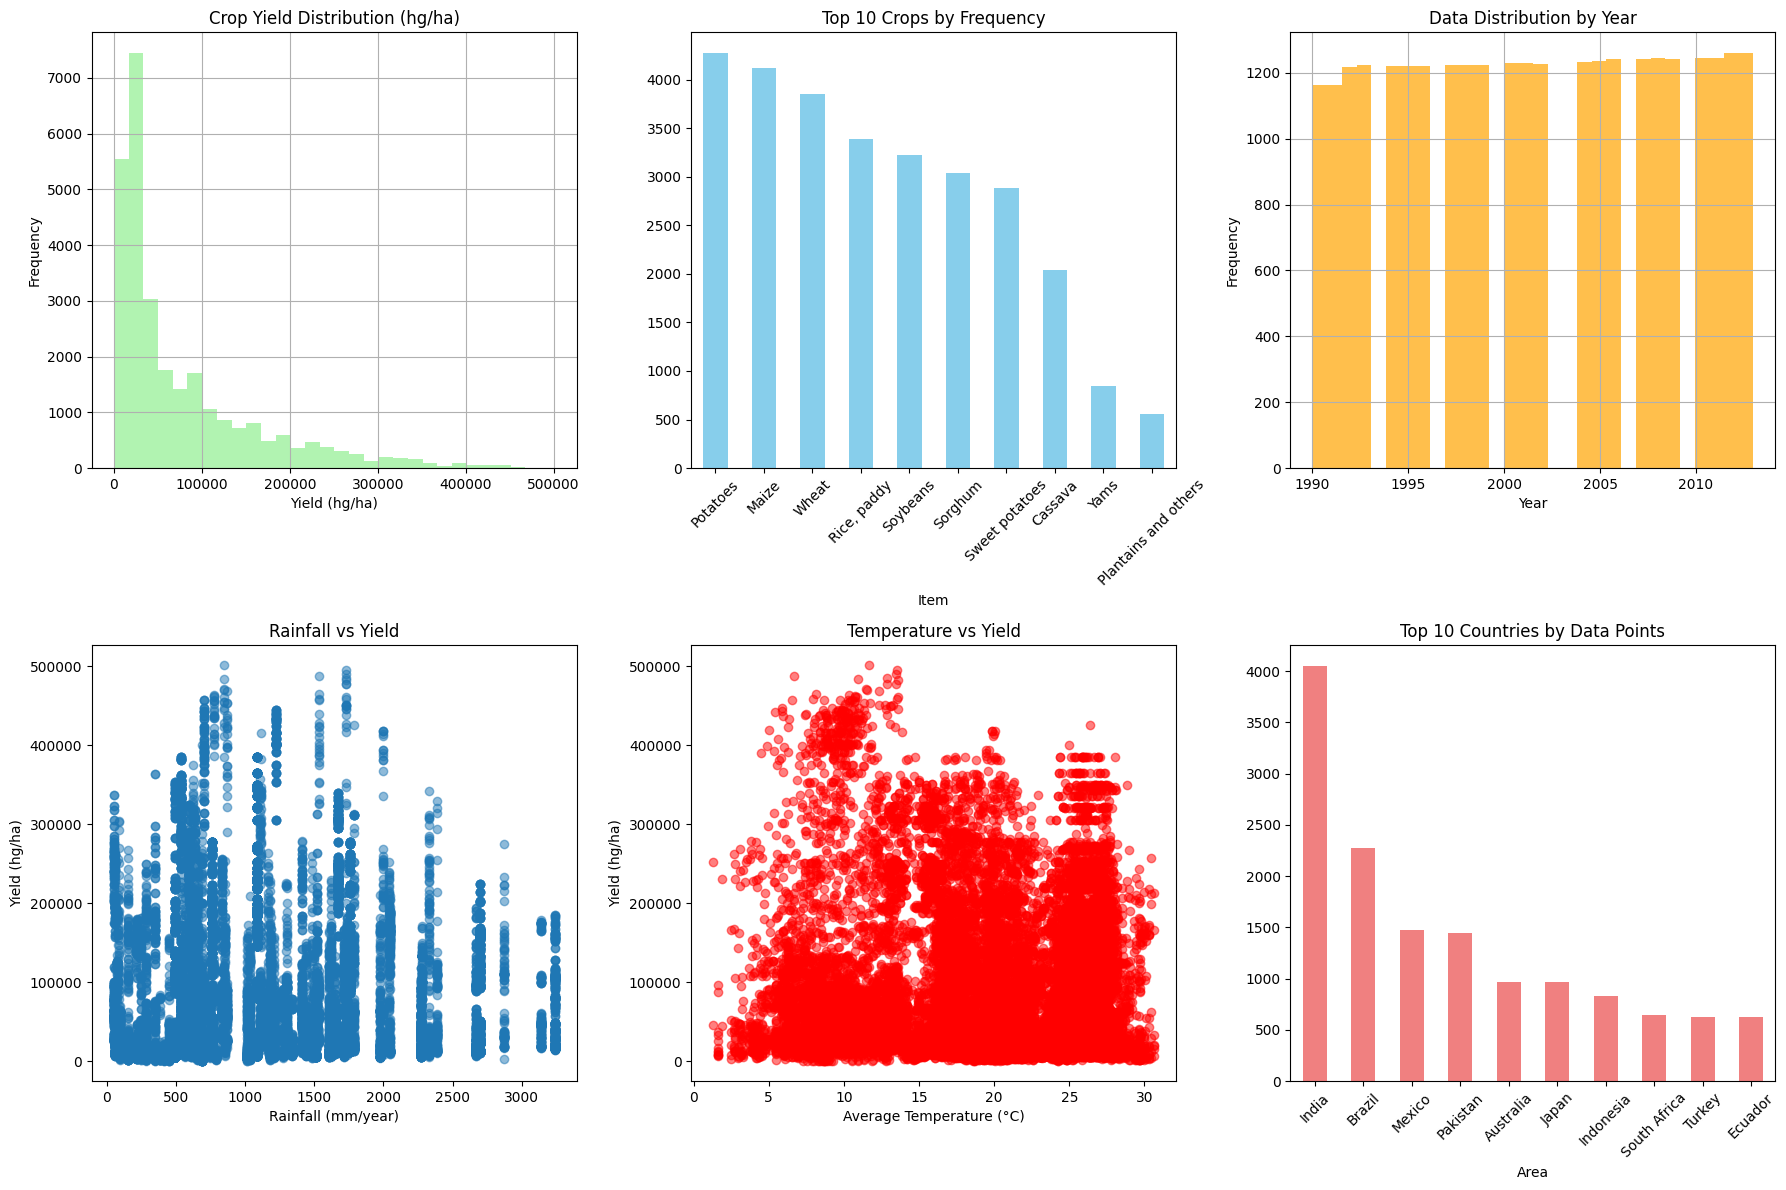

In [8]:
def exploratory_visualizations(df):
    """Create comprehensive visualizations"""
    
    print("\n📈 EXPLORATORY DATA VISUALIZATIONS")
    print("="*50)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Yield distribution
    df['hg/ha_yield'].hist(ax=axes[0,0], bins=30, color='lightgreen', alpha=0.7)
    axes[0,0].set_title('Crop Yield Distribution (hg/ha)')
    axes[0,0].set_xlabel('Yield (hg/ha)')
    axes[0,0].set_ylabel('Frequency')
    
    # 2. Top crops by count
    top_crops = df['Item'].value_counts().head(10)
    top_crops.plot(kind='bar', ax=axes[0,1], color='skyblue')
    axes[0,1].set_title('Top 10 Crops by Frequency')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Year distribution
    df['Year'].hist(ax=axes[0,2], bins=30, color='orange', alpha=0.7)
    axes[0,2].set_title('Data Distribution by Year')
    axes[0,2].set_xlabel('Year')
    axes[0,2].set_ylabel('Frequency')
    
    # 4. Rainfall vs Yield
    axes[1,0].scatter(df['average_rain_fall_mm_per_year'], df['hg/ha_yield'], alpha=0.5)
    axes[1,0].set_title('Rainfall vs Yield')
    axes[1,0].set_xlabel('Rainfall (mm/year)')
    axes[1,0].set_ylabel('Yield (hg/ha)')
    
    # 5. Temperature vs Yield
    axes[1,1].scatter(df['avg_temp'], df['hg/ha_yield'], alpha=0.5, color='red')
    axes[1,1].set_title('Temperature vs Yield')
    axes[1,1].set_xlabel('Average Temperature (°C)')
    axes[1,1].set_ylabel('Yield (hg/ha)')
    
    # 6. Top countries
    top_countries = df['Area'].value_counts().head(10)
    top_countries.plot(kind='bar', ax=axes[1,2], color='lightcoral')
    axes[1,2].set_title('Top 10 Countries by Data Points')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

exploratory_visualizations(master_df)